* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import os.path as path
from skimage.feature import hog
from scipy.ndimage.measurements import label
import collections
from moviepy.editor import VideoFileClip
import os

# HOG

<class 'list'>
8792
<class 'list'>
8968


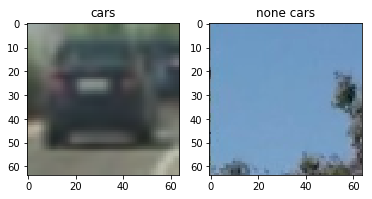

In [2]:
cars_directory = '.\\vehicles\\vehicles\\*\\*.png'
none_cars_directory = '.\\non-vehicles\\non-vehicles\\*\\*.png'

car_images = glob.glob(cars_directory)
none_car_images = glob.glob(none_cars_directory)

car_example = mpimg.imread(car_images[0])
none_car_example = mpimg.imread(none_car_images[0])
f,ax = plt.subplots(1,2)
f.set_facecolor('white')
ax[0].imshow(car_example)
ax[0].set_title('cars')
ax[1].imshow(none_car_example)
ax[1].set_title('none cars')
#plt.show()
print(type(car_images))
print(len(car_images))
print(type(none_car_images))
print(len(none_car_images))

#cars = []
#non_cars = []
#for image in car_images:
#    cars.append(image)
#print(type(cars))
#print(len(cars))

In [3]:

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [200, 700] # Min and max in y to search in slide_window()
time_window = 5

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features


In [5]:
%matplotlib qt

car_example = mpimg.imread(car_images[0])
none_car_example = mpimg.imread(none_car_images[0])
car_example_features, car_hog_image = get_hog_features(car_example, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
none_example_features, none_car_hog_image = get_hog_features(none_car_example, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

plt.figure('HoG outputs')
#plt.tight_layout()
plt.subplot(2,2,1)
plt.imshow(car_example)

plt.title('cars')

plt.subplot(2,2,2)
plt.imshow(none_car_example)
#plt.tight_layout()
plt.title('none cars')
#plt.xlabel('x-label', fontsize=12)
#plt.ylabel('y-label', fontsize=12)

plt.subplot(2,2,3)
plt.imshow(car_hog_image)
#plt.tight_layout()
plt.title('cars hog')

plt.subplot(2,2,4)
plt.imshow(none_car_hog_image)
plt.tight_layout()
plt.title('none cars hog')


Text(0.5,1,'none cars hog')

In [6]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [7]:
def bin_spatial(img,size = (32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
    #features = cv2.resize(img,size).ravel()
    #return features

In [8]:
def color_hist(img,nbins=32,bins_range=(0,256)):
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))
    return hist_features

In [9]:
def single_img_features(img,color_space='RGB',spatial_size = (32,32),hist_bins = 32,
                       orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=0,
                       spatial_feat=True,hist_feat=True,hog_feat=True):
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    if spatial_feat == True:
        spatial_featutes = bin_spatial(feature_image,size = spatial_size)
        img_features.append(spatial_featutes)
    if hist_feat == True:
        hist_features = color_hist(feature_image,nbins = hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        #
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                                    orient,pix_per_cell,cell_per_block,
                                                    vis = False,feature_vec = True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                               orient,pix_per_cell,cell_per_block,
                                               vis = False,feature_vec = True)
        img_features.append(hog_features)
    return np.concatenate(img_features)

In [10]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs,color_space='RGB',spatial_size = (32,32),hist_bins = 32,
                       orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=0,
                       spatial_feat=True,hist_feat=True,hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        hog_features = single_img_features(image,color_space=color_space,spatial_size =spatial_size,hist_bins = hist_bins,
                       orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel,
                       spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)
        features.append(hog_features)
    # Return list of feature vectors
    return features


In [11]:
print(len(car_images)+len(none_car_images))

17760


In [12]:
t=time.time()
print('Start to extract HOG features!')
car_features = extract_features(car_images,color_space=color_space,spatial_size = spatial_size,
                            hist_bins = hist_bins,orient=orient,pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                            hog_channel=hog_channel,spatial_feat=spatial_feat,
                                hist_feat=hist_feat,hog_feat=hog_feat)
notcar_features = extract_features(none_car_images,color_space=color_space,spatial_size = spatial_size,
                            hist_bins = hist_bins,orient=orient,pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                            hog_channel=hog_channel,spatial_feat=spatial_feat,
                                   hist_feat=hist_feat,hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print(X.shape)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Start to extract HOG features!
110.85 Seconds to extract HOG features...
(17760, 6108)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
6.59 Seconds to train SVC...
Test Accuracy of SVC =  0.989
My SVC predicts:  [1. 1. 1. 1. 0. 1. 1. 1. 0. 0.]
For these 10 labels:  [0. 1. 1. 1. 0. 1. 1. 1. 0. 0.]
0.01296 Seconds to predict 10 labels with SVC


# Sliding Window

In [13]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    #if not x_start_stop and not y_start_stop:
    #    x_start_stop = [0,img.shape[1]]
    #    y_start_stop = [0,img.shape[0]]
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    print(image.shape)
    print(x_start_stop)
    print(y_start_stop)
    # Compute the span of the region to be searched
    span_region = [x_start_stop[1]-x_start_stop[0],y_start_stop[1]-y_start_stop[0]]
    print(span_region)
    # Compute the number of pixels per step in x/y
    x_pixels_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    y_pixels_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    # Compute the number of windows in x/y
    x_number_windows = np.int((span_region[0]-np.int(xy_window[0]*xy_overlap[0]))/x_pixels_per_step)
    y_number_windows = np.int((span_region[1]-np.int(xy_window[1]*xy_overlap[1]))/y_pixels_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for xs in range(x_number_windows):
        for ys in range(y_number_windows):
            startx = xs*x_pixels_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*y_pixels_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list


In [14]:

image = mpimg.imread('.\\test_images\\test4.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)     
plt.figure()
plt.imshow(window_img)

(720, 1280, 3)
[0, 1280]
[0, 720]
[1280, 720]


In [15]:
def search_windows(img,windows,clf,scaler,color_space='RGB',
                   spatial_size = (32,32),hist_bins = 32,
                   hist_range=[0,256],
                  orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=0,
                  spatial_feat=True,hist_feat=True,hog_feat=True):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0]],(64,64))
        features = single_img_features(test_img,color_space=color_space,spatial_size = spatial_size,
                            hist_bins = hist_bins,orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                            hog_channel=hog_channel,spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)
        #print('test_features_length:{}'.format(features.shape))
        test_features = scaler.transform(np.array(features).reshape(1,-1))
        #print(123456)
        prediction = clf.predict(test_features)
        if prediction ==1:
            on_windows.append(window)
    return on_windows

In [16]:

image = mpimg.imread('.\\test_images\\test3.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[300, 700], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
print('窗口数量',len(windows))
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)     
plt.figure()
plt.imshow(window_img)


(720, 1280, 3)
[0, 1280]
[300, 700]
[1280, 400]
窗口数量 175


In [17]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [18]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins,show_status = False):
    hot_windows = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    if show_status == False:
        return hot_windows
    else:
        return hot_windows,draw_img


In [19]:
image = mpimg.imread('.\\test_images\\test4.jpg')    
ystart = 400
ystop = 656
scale = 1.5
    
hot_windows,out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,True)

plt.imshow(out_img)

In [20]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [21]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [22]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

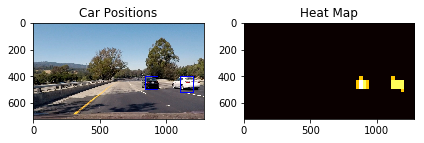

In [23]:
%matplotlib inline

image = mpimg.imread('.\\test_images\\test4.jpg')  
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [24]:
def vehicle_detection_pipline(frame,ystart,ystop=ystop,scale=scale,svc=svc,X_scaler=X_scaler,orient=orient,
                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins,
                              show_status=False):
    hot_windows = []
    for subsample in np.arange(1,3,0.5):
        hot_windows += find_cars(frame, ystart, ystop, scale, svc, X_scaler, orient, 
                                 pix_per_cell, cell_per_block, spatial_size, hist_bins,False)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,4)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(frame), labels)
    if show_status == True:
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    return draw_img

In [25]:
def vehicle_dectection_video(frame):
    draw_img = vehicle_detection_pipline(frame,ystart=ystart,ystop=ystop,scale=scale,svc=svc,X_scaler=X_scaler,orient=orient,
                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins,
                              show_status=False)
    return draw_img

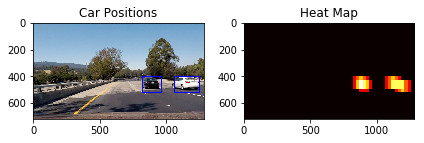

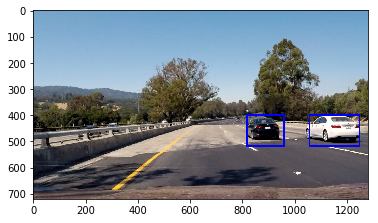

In [26]:
#%matplotlib qt
frame = mpimg.imread('.\\test_images\\test4.jpg')  
a=vehicle_detection_pipline(frame,ystart,ystop,scale,svc,X_scaler,orient,
                              pix_per_cell, cell_per_block, spatial_size, hist_bins,
                              show_status=True)
plt.figure()
plt.imshow(a)


In [28]:
model = 'video'
if model == 'video':
    selector = 'project'
    clip = VideoFileClip('{}_video.mp4'.format(selector)).fl_image(vehicle_dectection_video)
    clip.write_videofile('out_{}_video.mp4'.format(selector),audio = False)
else:
    test_img_dir = 'test_images'
    for test_image in os.listdir(test_img_dir):
        frame = mpimg.imread(os.path.join(test_img_dir,test_image))
        output_image = vehicle_detection_pipline(frame,ystart,ystop,scale,svc,X_scaler,orient,
                              pix_per_cell, cell_per_block, spatial_size, hist_bins,
                              show_status=False)
        output_image = cv2.cvtColor(output_image,cv2.COLOR_RGB2BGR)
        cv2.imwrite('output_images/{}'.format(test_image),output_image)
        plt.figure()
        plt.imshow(output_image)

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4



  0%|          | 5/1261 [00:22<1:33:50,  4.48s/it]

KeyboardInterrupt: 